In [26]:
import bz2
import pickle
import zipfile
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from gensim.models import LdaModel, Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from gensim import corpora
from itertools import chain
from nltk.corpus import gutenberg, brown

In [3]:
# Step 1: Load the Wikipedia dataset from the BZIP2 compressed file in chunks
bz2_file_path = 'E:\Downloads\Machine Learning\ML Ex 2\enwiki-latest.csv.bz2'

word_freq = Counter()  # Initialize an empty counter

with bz2.open(bz2_file_path, 'rt', encoding='utf-8') as file:
    chunk_size = 5 * 1024 * 1024  # 1 MB chunk size
    while True:
        chunk = file.read(chunk_size)
        if not chunk:
            break
        words = chunk.split()  # Tokenize the chunk into words
        word_freq.update(words)  # Update word frequency counter

In [4]:
# Step 2: Pickle the word frequency counter and save it into a file

pickle_file_path = 'word_freq.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(word_freq, f)

In [5]:
# Step 3: Load the data from the pickle file
with open(pickle_file_path, 'rb') as f:
    loaded_word_freq = pickle.load(f)

In [6]:
# Step 4: Calculate the number of unique words and total number of words
num_unique_words = len(loaded_word_freq)
total_words = sum(loaded_word_freq.values())

In [7]:
# Step 5: Find the 20 most frequent words and their respective frequencies
top_20_words = loaded_word_freq.most_common(20)

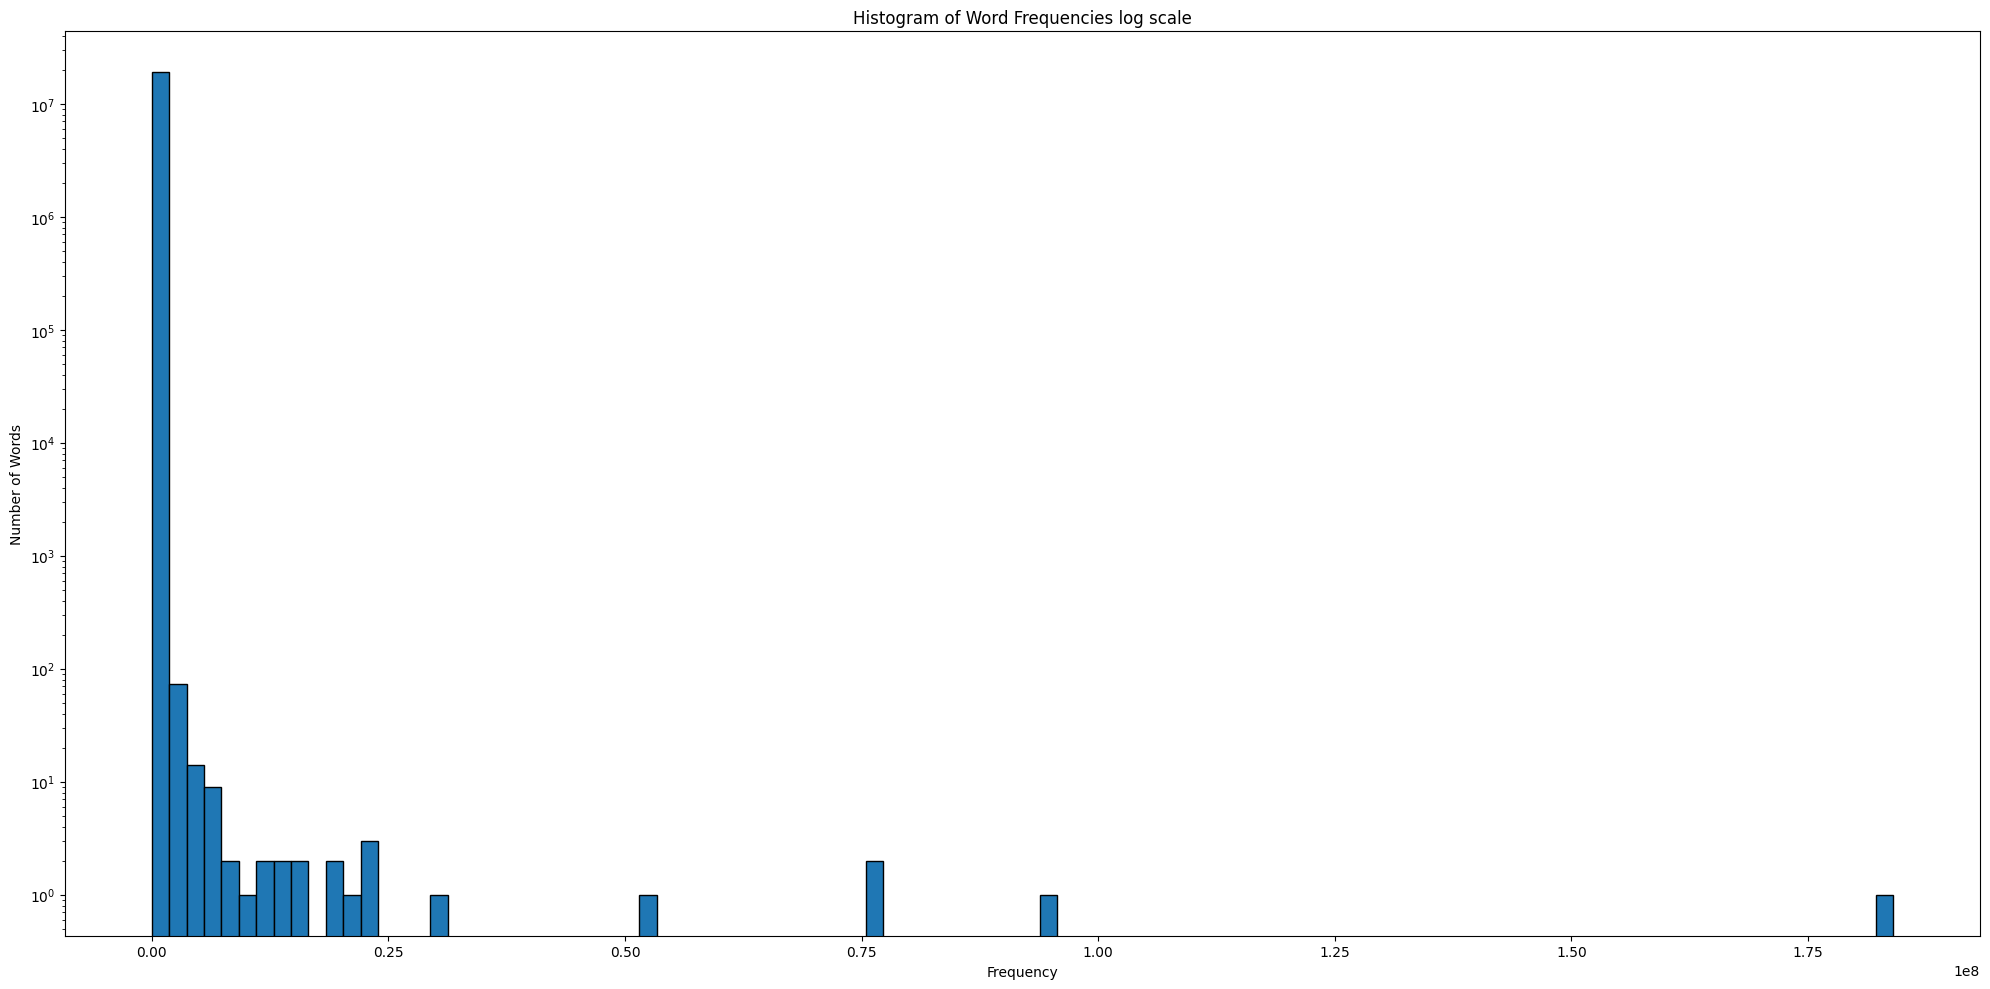

In [9]:
# Step 6: Plot a histogram of word frequencies
plt.figure(figsize=(20,10))
freq_values = list(loaded_word_freq.values())
plt.hist(freq_values, bins=100, edgecolor='black', log=True)
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequencies log scale')
plt.tight_layout()
plt.show()

Answer: For the graph we can see that we mainly have 2 groups of words, one that are used a lot (bigger in scale), and words that are very rare.

In [10]:
# Print the results
print("a. Number of unique words:", num_unique_words)
print("b. Total number of words:", total_words)
print("c. List of 20 most frequent words and their fraction of data:")
for word, freq in top_20_words:
    fraction = freq / total_words
    print(f"{word}: {fraction:.5f}")

a. Number of unique words: 18927384
b. Total number of words: 2736624354
c. List of 20 most frequent words and their fraction of data:
the: 0.06722
of: 0.03433
and: 0.02809
in: 0.02763
to: 0.01902
was: 0.01089
is: 0.00866
for: 0.00832
on: 0.00809
as: 0.00803
by: 0.00715
with: 0.00697
he: 0.00555
at: 0.00552
from: 0.00525
that: 0.00517
his: 0.00445
it: 0.00427
an: 0.00370
were: 0.00290


Answer: As we can see the 20 most common words are stopwords, which are words that are very popular and widely used.

In [2]:
# Path to the zip file
zip_file_path = 'Books.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Read books.csv directly from the zip archive
    with zip_ref.open('books.csv') as books_file:
        books_df = pd.read_csv(books_file)
    
    # Read ratings.csv directly from the zip archive
    with zip_ref.open('ratings.csv') as ratings_file:
        ratings_df = pd.read_csv(ratings_file)

In [12]:
print(books_df.columns)

Index(['book_id', 'authors', 'original_publication_year', 'original_title',
       'language_code'],
      dtype='object')


In [13]:
print(ratings_df.columns)

Index(['user_id', 'book_id', 'rating'], dtype='object')


In [6]:
print("Missing values in books_df:")
print(books_df.isnull().sum())

Missing values in books_df:
book_id                         0
authors                         0
original_publication_year      21
original_title                585
language_code                1084
dtype: int64


In [7]:
print("\nMissing values in ratings_df:")
print(ratings_df.isnull().sum())


Missing values in ratings_df:
user_id    0
book_id    0
rating     0
dtype: int64


In [3]:
# Create a dictionary to map user IDs to a unique index
index_dict = {user_id: index for index, user_id in enumerate(ratings_df['user_id'].unique())}

In [4]:
# Create an array to store the BoW representation of user IDs for each book
corpus = []

# Iterate through each book
for index, book in books_df.iterrows():
    book_id = book['book_id']
    # Get the list of user IDs who rated this book
    users_rated = ratings_df[ratings_df['book_id'] == book_id]['user_id']
    # Convert user IDs to their corresponding index
    users_rated_indices = [index_dict[user_id] for user_id in users_rated]
    # Append the BoW representation of user IDs for this book to the corpus
    corpus.append([(user_index, 1) for user_index in users_rated_indices])

dict = corpora.Dictionary.from_corpus(corpus)

In [5]:
# Step 2: Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dict, num_topics=20, passes=50, random_state=42)

In [6]:
# Step 3: Get topic distributions for each book
book_topic_dist = [lda_model[doc] for doc in corpus]

In [7]:
# Step 5: Find similar books
def book_recommender(book_id, num_similar_books=10):
    # Get the document-topic distribution of the given book
    book_vector = np.array(lda_model.get_document_topics(corpus[book_id], minimum_probability=0))[:, 1]

    # Normalize the document-topic distribution
    book_vector /= np.sum(book_vector)

    # Get document-topic distributions for all books and normalize them
    book_topic_dist_matrix = np.zeros((len(corpus), lda_model.num_topics))
    for i, doc in enumerate(corpus):
        doc_topics = lda_model.get_document_topics(doc, minimum_probability=0)
        for topic_id, topic_prob in doc_topics:
            book_topic_dist_matrix[i, topic_id] = topic_prob
        book_topic_dist_matrix[i] /= np.sum(book_topic_dist_matrix[i])

    # Compute cosine similarity between the given book and all other books
    similarity_scores = cosine_similarity(book_vector.reshape(1, -1), book_topic_dist_matrix)[0]

    # Sort the similarity scores and get the indices of most similar books
    similar_book_indices = sorted(enumerate(similarity_scores), key=lambda x: x[1], reverse=True)[:num_similar_books]

    # Retrieve the titles of the most similar books
    similar_books = [(books_df.iloc[i]['book_id'], books_df.iloc[i]['original_title'], score) for i, score in similar_book_indices]

    return similar_books

In [12]:
# Test the book recommender
# Initialize the recommendations dictionary
recommendations = {}

# List of books to test on
book_ids = [17, 113, 511]  

# Iterate over each book ID
for book_id in book_ids:
    similar_books = book_recommender(book_id)
    
    # Initialize an empty list to store results for the current book
    results = []
    
    # Accumulate the results for the current book ID
    for id, title, score in similar_books:
        results.append({
            'Book ID': id,
            'Similar Book': title,
            'Similarity Score': score
        })
    
    # Store the results for the current book ID in the dictionary
    recommendations[book_id] = pd.DataFrame(results)

# Display results for each book in separate DataFrames
for book_id, df in recommendations.items():
    original_title = books_df.iloc[book_id]['original_title']
    print(f"Books similar to '{original_title}':")
    display(df[['Book ID', 'Similar Book', 'Similarity Score']])
    print()


Books similar to 'Harry Potter and the Prisoner of Azkaban':


,Book ID,Similar Book,Similarity Score
0,17,Harry Potter and the Prisoner of Azkaban,1.000000
1,22,Harry Potter and the Chamber of Secrets,0.999697
2,23,Harry Potter and the Goblet of Fire,0.999518
3,20,Harry Potter and the Order of the Phoenix,0.998173
4,26,Harry Potter and the Half-Blood Prince,0.998106
5,24,Harry Potter and the Deathly Hallows,0.997639
6,1,Harry Potter and the Philosopher's Stone,0.953603
7,421,Complete Harry Potter Boxed Set,0.944439
8,506,The Hunger Games Box Set,0.897665
9,61,Northern Lights,0.893558



Books similar to 'Tuesdays with Morrie':


,Book ID,Similar Book,Similarity Score
0,113,Tuesdays with Morrie,1.000000
1,131,The Five People You Meet in Heaven,0.981734
2,39,"Eat, pray, love: one woman's search for everyt...",0.939969
3,10,The Kite Runner,0.937347
4,328,The Last Lecture,0.934212
5,8778,Waiting to Exhale,0.930510
6,74,NaN,0.929022
7,32,Memoirs of a Geisha,0.928709
8,37,The Time Traveler's Wife,0.928546
9,65,Gone with the Wind,0.925695



Books similar to 'The Complete Tales of Edgar Allan Poe':


,Book ID,Similar Book,Similarity Score
0,511,The Complete Tales of Edgar Allan Poe,1.000000
1,5568,The Monkey's Paw,0.992901
2,2467,The Pit and the Pendulum,0.990462
3,401,The Tell-Tale Heart,0.990410
4,2198,The Lottery: Adventures of the Demon Lover,0.988359
5,2369,The Legend of Sleepy Hollow,0.987457
6,1705,The Fall of the House of Usher and Other Writings,0.983781
7,3100,The Raven and Other Poems,0.983426
8,7114,The Complete Phantom of the Opera,0.978442
9,2364,The Cask of Amontillado,0.977886


Answer: As we can see the book recommeder works fine, and gives books from similar genres and authors.

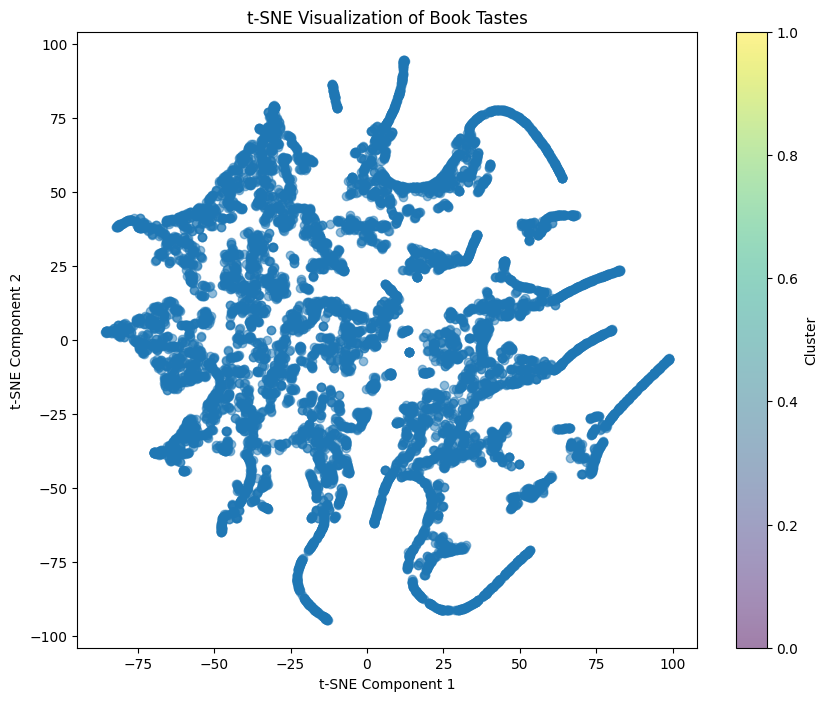

In [13]:
# Step 6: visuallize clusters of book tastes
# Initialize an empty list to store topic distributions
topic_dist_list = []

# Iterate through each book's topic distribution and append it to the list
for topic_dist in book_topic_dist:
    dist_array = np.zeros(lda_model.num_topics)  # Initialize an array for the topic distribution
    for topic_id, prob in topic_dist:
        dist_array[topic_id] = prob  # Fill the array with the probabilities
    topic_dist_list.append(dist_array)

# Convert the list of arrays into a NumPy array
topic_dist_array = np.array(topic_dist_list)

# Apply t-SNE to reduce dimensionality
tsne = TSNE(init='pca', random_state=42)
tsne_result = tsne.fit_transform(topic_dist_array)

# Visualize clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Book Tastes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [16]:
# Step 7: Perform Clustering
num_clusters = 7

# Initialize KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# Fit KMeans to the data
kmeans.fit(tsne_result)
# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the books DataFrame
books_df['cluster'] = cluster_labels

In [24]:
# Step 8: Explore the characteristics of each cluster
cluster_char = {}

for cluster_id in range(num_clusters):
    # Filter books belonging to the current cluster
    cluster_books = books_df[books_df['cluster'] == cluster_id]

    # Initialize an empty list to store selected books
    selected_books = []

    # Randomly select books from the cluster until at least 5 valid books are selected
    while len(selected_books) < 5:
        # Sample a book from the cluster
        sampled_book = cluster_books.sample(n=1)
        
        # Check if the 'original_title' of the sampled book is NaN
        if pd.notnull(sampled_book['original_title'].iloc[0]):
            selected_books.append(sampled_book['original_title'].iloc[0])

    # Store cluster characteristics
    cluster_char[cluster_id] = {
        'num_books': len(cluster_books),
        'selected_books': selected_books
    }

    print(f"Cluster {cluster_id}:")
    print(f"Number of books: {len(cluster_books)}")
    print("Selected Books:")
    for book_title in selected_books:
        print(f"* {book_title}")
    print()

Cluster 0:
Number of books: 1523
Selected Books:
* The Face on the Milk Carton
* Finding Cassie Crazy
* Kiss the Dead
* A Touch of Dead
* The Story of Ferdinand

Cluster 1:
Number of books: 1540
Selected Books:
* Notes on a Scandal
* The Weed That Strings the Hangman's Bag
* The Obituary Writer
* The Secret Life of Violet Grant
* The Two-Family House

Cluster 2:
Number of books: 1549
Selected Books:
* Dream Team
* Revolutionary Road
* The Things They Carried
* Getting Stoned with Savages: A Trip Through the Islands of Fiji and Vanuatu
* The Last of the Mohicans: A Narrative of 1757

Cluster 3:
Number of books: 1499
Selected Books:
* Knight & Play
* The Goddess Test
* Six's Legacy
* Megan Meade's Guide to the McGowan Boys
* The Reef

Cluster 4:
Number of books: 1441
Selected Books:
* Ancillary Justice
* First King of Shannara
* Sex Criminals, Volume One: One Weird Trick
* 桜蘭高校ホスト部 2
* White Night

Cluster 5:
Number of books: 1331
Selected Books:
* The Taste of Home Cookbook
* Act Like a

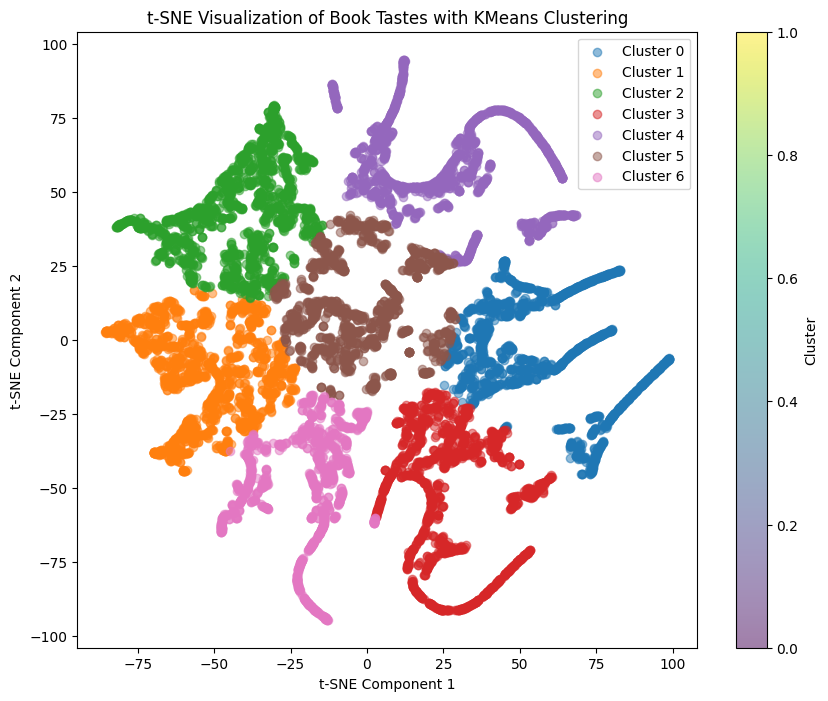

Cluster Characteristics:
Cluster 0: {'num_books': 1523, 'selected_books': ['The Face on the Milk Carton', 'Finding Cassie Crazy', 'Kiss the Dead', 'A Touch of Dead', 'The Story of Ferdinand']}
Cluster 1: {'num_books': 1540, 'selected_books': ['Notes on a Scandal', "The Weed That Strings the Hangman's Bag", 'The Obituary Writer', 'The Secret Life of Violet Grant', 'The Two-Family House']}
Cluster 2: {'num_books': 1549, 'selected_books': ['Dream Team', 'Revolutionary Road', 'The Things They Carried', 'Getting Stoned with Savages: A Trip Through the Islands of Fiji and Vanuatu', 'The Last of the Mohicans: A Narrative of 1757']}
Cluster 3: {'num_books': 1499, 'selected_books': ['Knight & Play', 'The Goddess Test', "Six's Legacy", "Megan Meade's Guide to the McGowan Boys", 'The Reef']}
Cluster 4: {'num_books': 1441, 'selected_books': ['Ancillary Justice', 'First King of Shannara', 'Sex Criminals, Volume One: One Weird Trick', '桜蘭高校ホスト部 2', 'White Night']}
Cluster 5: {'num_books': 1331, 'sel

In [25]:
#Step 9: Visualize clusters with t-SNE
plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    plt.scatter(tsne_result[cluster_indices, 0], tsne_result[cluster_indices, 1], label=f'Cluster {cluster_id}',
                alpha=0.5)

plt.title('t-SNE Visualization of Book Tastes with KMeans Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.colorbar(label='Cluster')
plt.show()

# Display cluster characteristics
print("Cluster Characteristics:")
for cluster_id, characteristics in cluster_char.items():
    print(f"Cluster {cluster_id}: {characteristics}")

Answer: This could be further enhanced by introducing the amount of sales for each cluster. As a book store you will not buy unpopular books, promote more popular books and could be able to recommend similar books to buyrs and as such increase sales.

In [34]:
# Download the Gutenberg, and Reuters corpora
nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('brown')


# Load texts from Gutenberg, Brown corpora
gutenberg_sentences = gutenberg.sents()
brown_sentences = brown.sents()

# Combine sentences from all corpora
all_sentences = list(chain(gutenberg_sentences, brown_sentences))

# Train the Word2Vec model with adjusted parameters
model = Word2Vec(all_sentences, window=8, min_count=5, workers=8, sg=1, epochs=100)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\doron\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\doron\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [35]:
# Explore the trained Word2Vec model with additional examples
similar_words_home = model.wv.most_similar('cake', topn=10)
print("Similar words to 'cake':", similar_words_home)

similar_words_water = model.wv.most_similar('hat', topn=10)
print("Similar words to 'hat':", similar_words_water)

similar_words_book = model.wv.most_similar('time', topn=10)
print("Similar words to 'time':", similar_words_book)

Similar words to 'cake': [('basket', 0.581057608127594), ('salad', 0.5710272192955017), ('cheese', 0.5677143931388855), ('hamburger', 0.5495600700378418), ('baken', 0.5475761294364929), ('raisins', 0.5359114408493042), ('beverage', 0.5326988101005554), ('butter', 0.5268170237541199), ('tray', 0.524599015712738), ('bread', 0.5199547410011292)]
Similar words to 'hat': [('coat', 0.6610189080238342), ('frock', 0.6254614591598511), ('beaver', 0.574442446231842), ('silk', 0.5698276162147522), ('black', 0.5662074685096741), ('head', 0.5647312998771667), ('straw', 0.563631534576416), ('pocket', 0.5586637854576111), ('boots', 0.5461484789848328), ('slouched', 0.5422832369804382)]
Similar words to 'time': [('last', 0.6347706913948059), ('period', 0.5951306819915771), ('first', 0.5888474583625793), ('moment', 0.5729201436042786), ('day', 0.5715351700782776), ('same', 0.5633336305618286), ('at', 0.5612948536872864), ('week', 0.5308361649513245), ('elapsed', 0.5231456160545349), ('short', 0.5172712

In [37]:
# Calculate similarity between pairs of words
similarity_water_ice = model.wv.similarity('home', 'house')
print("Similarity between 'home' and 'house':", similarity_water_ice)

similarity_car_engine = model.wv.similarity('face', 'nose')
print("Similarity between 'face' and 'nose':", similarity_car_engine)

similarity_man_woman = model.wv.similarity('clock', 'talk')
print("Similarity between 'clock' and 'talk':", similarity_man_woman)

similarity_cat_book = model.wv.similarity('game', 'sword')
print("Similarity between 'game' and 'sword':", similarity_cat_book)

Similarity between 'home' and 'house': 0.4073728
Similarity between 'face' and 'nose': 0.5431194
Similarity between 'clock' and 'talk': 0.29265448
Similarity between 'game' and 'sword': 0.23490205


In [38]:
# Evaluate Word2Vec model with the revised evaluation dataset names
simlex_file = 'SimLex-999.tsv'
wordsim_file = 'WordSim353.tsv'

similarity_scores_simlex = model.wv.evaluate_word_pairs(simlex_file)
similarity_scores_wordsim = model.wv.evaluate_word_pairs(wordsim_file)

print("\nSimilarity scores for SimLex-999:")
print(similarity_scores_simlex)

print("\nSimilarity scores for WordSim353:")
print(similarity_scores_wordsim)


Similarity scores for SimLex-999:
(PearsonRResult(statistic=0.1392867830391416, pvalue=1.0679924296771508e-05), SignificanceResult(statistic=0.14854285656373115, pvalue=2.6182020130045496e-06), 0.7007007007007007)

Similarity scores for WordSim353:
(PearsonRResult(statistic=0.4545289255887974, pvalue=3.862501666827147e-16), SignificanceResult(statistic=0.4742136472455168, pvalue=1.3066798677543653e-17), 18.13031161473088)


Answer: In a general manner we can see that W2V works well, but as seen from the examples of house and home, the model gives relativly low scores (to human preception). This indicates that more sophisticated models may capture much more meaning. we can also see that W2V works much better on wordsim than on simlex which might be due to the text composition and/or distribution of words.